  # Primary statistical testing workflow

This is the primary statistical testing workflow we are recommending.  This should work for the majority of cases in small molecule property prediction.


  ### Installation

  <pre>pip install pandas pingouin seaborn matplotlib scikit-learn</pre>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from scipy.stats import levene

from model_comparison import calc_regression_metrics, make_ci_plot_grid, make_mcs_plot_grid, make_normality_diagnostic, make_boxplots_parametric, make_scatterplot, rm_tukey_hsd

  ### 1. Read in data

In [4]:
df_input = pd.read_csv("Sol_results.csv")
df_input = df_input[df_input['dset'] == 'test']

methods = list(df_input.columns[-3:])
df_melted = pd.melt(df_input, id_vars=['fold', 'group', 'SMILES', 'Sol'],
                    value_vars=methods, var_name='method', value_name='Sol_pred')

df_melted.rename(columns={'fold': 'cv_cycle', 'group': 'split', 'Sol': 'Sol'}, inplace=True)
df_melted['Name'] = 'Mol' + (df_melted.index + 1).astype(str)

df_input = df_melted.copy()

# Solubilty was in log micromolar, adjust to log molar
df_input["Sol"] = df_input["Sol"] - 6
df_input["Sol_pred"] = df_input["Sol_pred"] - 6

  ### 2. Calculate Regression Metrics

In [5]:
classification_cutoff = -4
df_metrics = calc_regression_metrics(df_input, "cv_cycle", "Sol", "Sol_pred", classification_cutoff)
metric_ls = df_metrics.columns[3:]

Select the data generated from scaffold splits

In [6]:
df_scaffold_split = df_metrics.query("split == 'scaffold'")

  ### 3.  Current Suboptimal Practice in Many Papers (Don't do this!)

  Many papers that compare ML models simply show a table with the average of each metric over multiple folds of cross validation. The largest value is shown in bold and considered to be the "winner". **This not the correct way to represent a comparison!** Remember, we're comparing distributions, which should never be compared by simply using the mean.

In [7]:
row_list = []
for k, v in df_scaffold_split.groupby("method"):
    row_list.append([k, v.mae.mean(), v.mse.mean(), v.r2.mean(), v.rho.mean(), v.recall.mean(), v.prec.mean()])
terrible_df = pd.DataFrame(row_list, columns=["Method", "MAE", "MSE", "R2", "Rho", "Recall", "Precision"])

terrible_df.style.hide().format(precision=3).highlight_max(subset=["R2", "Rho", "Recall", "Precision"],
                                                                  props='font-weight: bold', axis=0) 

Method,MAE,MSE,R2,Rho,Recall,Precision
chemprop_mt,0.384,0.300,0.401,0.598,0.582,0.856
chemprop_st,0.369,0.299,0.404,0.598,0.661,0.840
lgbm_morgan,0.440,0.374,0.254,0.518,0.491,0.849


  ### 4. Selecting a statistical testing procedure

The following decision tree illustrates the key decisions you will need to make when selecting a statistical test for differences between models. Please keep in mind that this is not a cookbook and real life is often more complicated than this. We recommend  examining your data and the assumptions behind the models you are using. You may decide to deviate from this workflow based on the needs of your data. In absence of perfect solution for every scenario, transparency is key.

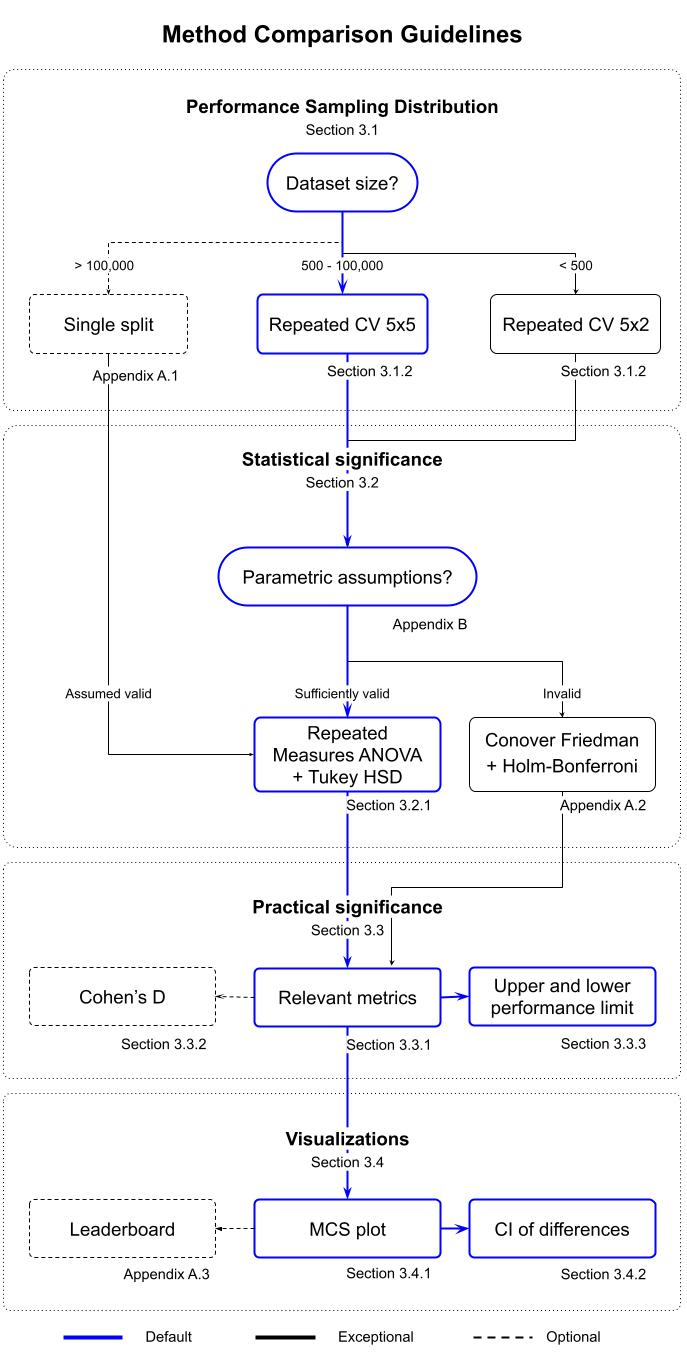

In [8]:
from IPython import display
display.Image("visual-abstract.jpg", width=500)

### 4.1 Choose the performance sampling mechanism

The first thing you need to decide is what splitting procedure to use. In this example we use 5x5 repeated CV since we have 2k solubility measurements.

### 4.2 Examine the parametric testing assumptions

We recommend the repeated measures ANOVA followed by Tukey HSD test for pairwise comparison of methods. We recommend always checking the parametric assumptions of the tests, but if you follow the performance sampling guidelines, these assumptions should be reasonably met in most applications in small molecule predictive modeling.

The tests make three assumptions that should be examined. The Tukey HSD test can be considered a special case of ANOVA, so both tests make the same assumptions. Note that the assumptions being made are on the distribution of performance metrics across CV splits, we are not making assumptions about the distribution of individual predictions. In order of importance: 

1. Independence: The samples (i.e., performance metrics across CV splits) should be independent. Information about one sample should not tell you anything about another sample. 

2. Homogeneity of Variances: The variance of the performance sampling distributions for each of the models are approximately equal. 

3. Normality: The performance metric distributions are assumed to be approximately normal for each model.   

If there are strong violations of **2** or **3**, see the [non-parametric workflow](https://github.com/polaris-hub/polaris-method-comparison/blob/main/ADME_example/supplementary_workflows/ML_Regression_Comparison_nonparametric.ipynb).


#### 4.2.1 The independence assumption

There is no straight-forward way to test for this, which is why the usage of appropriate sampling mechanisms (such as 5x5 repeated CV) is so important to ensure the samples are sufficiently independent. There is dependency introduced by the same splits being used across methods, but the repeated measures ANOVA to TukeyHSD workflow accounts for this.

#### 4.2.2 The homogeneity of variances assumption

A typical rule of thumb is that the ratio of the largest and smallest variance should not be larger than 3. However, in the case of equally sized groups, much larger variance ratios are tolerated and these can be as high as 9 (see [here](https://link.springer.com/article/10.3758/s13428-017-0918-2)). Since the same number of CV iterations are performed for each model in 5x5 repeated CV, the groups are equally sized. This assumption will rarely be violated.

You can test for differences between variances using the Levene test. The Levene test is significant for recall, but the variance fold differences are well below 9, so we conclude the variance assumption is not violated.  

In [9]:
for metric in metric_ls:
    groups = df_scaffold_split.groupby('method')[metric].apply(list)
    stat, pvalue = levene(*groups)
    print(f'Levene test for {metric}: p-value = {pvalue}')

Levene test for mae: p-value = 0.8253320811912848
Levene test for mse: p-value = 0.9323355194408104
Levene test for r2: p-value = 0.23196629981380434
Levene test for rho: p-value = 0.7132160181866819
Levene test for prec: p-value = 0.4603387501906694
Levene test for recall: p-value = 0.006583873494025223


In [10]:
variances_by_method = df_scaffold_split.groupby('method')[metric_ls].var()
max_fold_diff = variances_by_method.max() / variances_by_method.min()
print(max_fold_diff)

mae       1.507751
mse       1.355321
r2        1.773774
rho       1.350331
prec      1.472007
recall    5.506116
dtype: float64


#### 4.2.3 The normality assumption

ANOVA and Tukey HSD will be robust to moderate normality violations for the 25 samples collected by 5x5 repeated CV. Note that only approximate normality of the data generating population distribution is assumed. It can be difficult to examine this when sample sizes are small. In these cases, an argument is often made on the conceptual level for approximate normality.   This argument can be made for performance metrics since they are typically the sum of many variables (e.g., the sum of individual errors) and will be approximately normal due to the Central Limit Theorem. Since 25 samples are collected from each distribution, one is able to check for strong violations of normality. The best way of doing this is by visualizing the distribution. We recommend against using tests for normality (e.g. Kolmogorov-Smirnov) as they will have low statistical power. See [here](https://www.researchgate.net/publication/11454445_The_Importance_of_the_Normality_Assumption_in_Large_Public_Health_Data_Sets) and [here](https://psycnet.apa.org/record/2018-24694-018) for a review of the robustness of ANOVA to non-normality. 


With 5x5 = 25 CV replicates it is clear that the performance metric distributions are sufficiently normally distributed to perform the ANOVA.

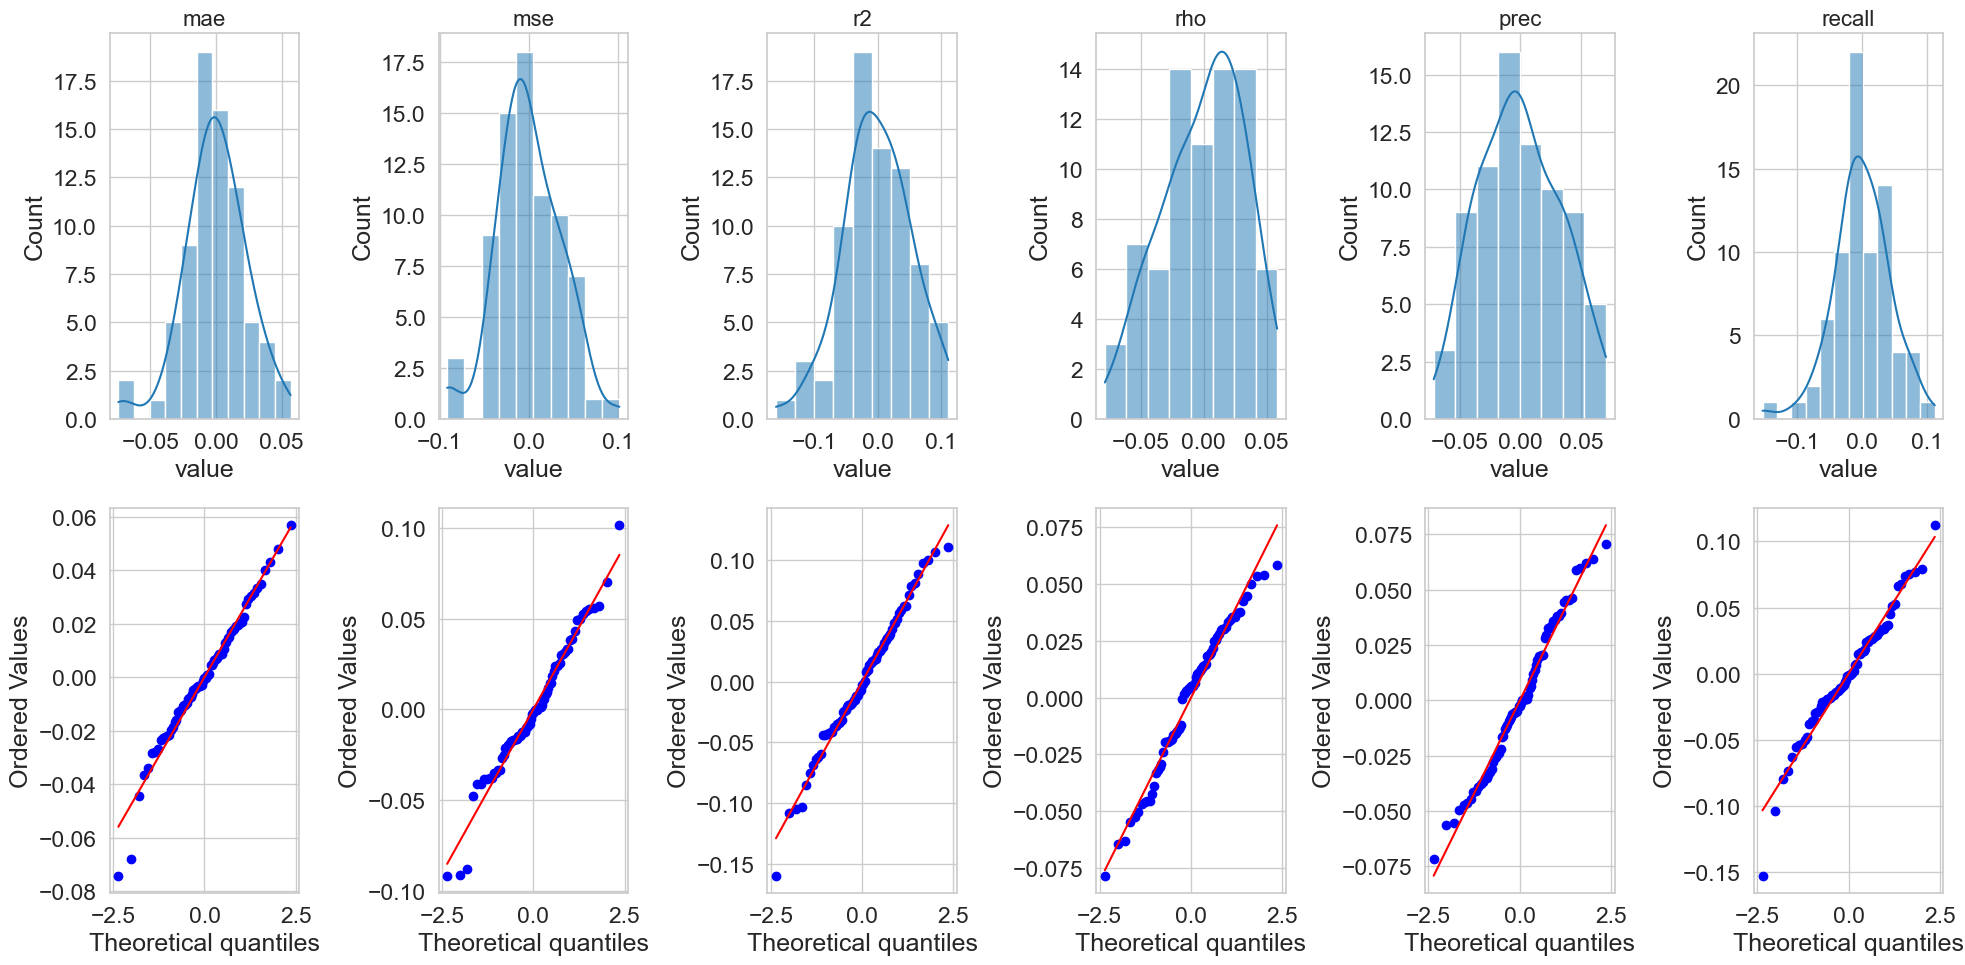

In [11]:
make_normality_diagnostic(df_scaffold_split.copy(), metric_ls)

## 5. Perform repeated measures ANOVA

Since the assumptions were not violated, we proceed through the parametric testing workflow. We start with a test for whether there is any difference between groups. Since the methods are using the same splits, there is dependency in the samples. We account for this using a repeated measures ANOVA.

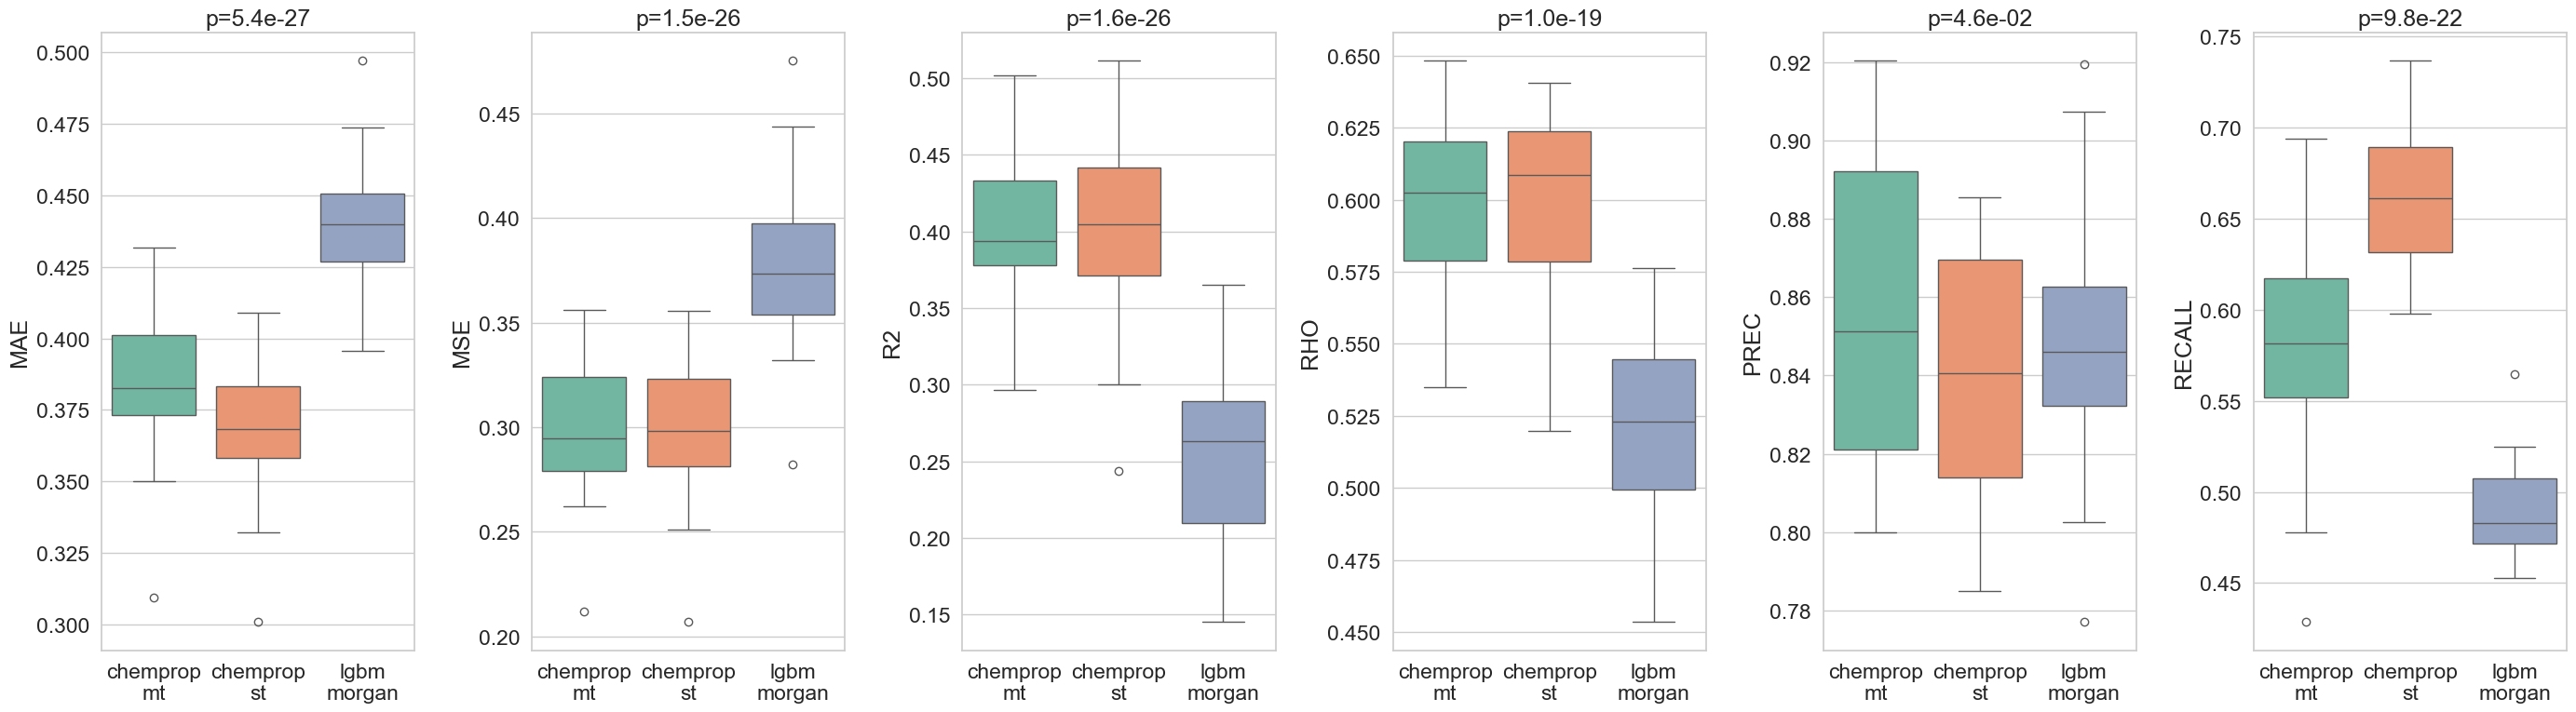

In [13]:
make_boxplots_parametric(df_scaffold_split, metric_ls)

  ## 6. Perform a Post-Hoc Analysis to Examine Differences Between Methods

  The ANOVA test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at individual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use Tukey's Honestly Significant Difference (HSD).

  ### 6.1 MCS Plots

Next we recommend useful plots for presenting the results of the pairwise comparisons. The first plot is an extension to the sign plot provided by [sci-kit posthocs](https://scikit-posthocs.readthedocs.io/en/latest/). The original sign plot showed p-value matrices color coded by statistical significance. But what was missing was an indication of effect size. Readers could look at pairs of methods and see statistical significance but be mislead if the effect size is not sufficiently large to be meaningful.

We call our extension a multiple comparisons similarity (MCSim) plot.  Methods on the rows and columns are sorted by average performance. The top left block of methods without statistically significant differences are the plausible top performers. Cells are colored by the difference in average performance between methods. Statistical significance is indicated with star annotations indicating the level of significance (* p < .05, ** p < .01, *** p< .001).

To set the color scale provide the smallest difference that would be considered practically significant. Sensible defaults are provided for the color scale for many metrics. Defaults are not provided for MAE of MSE because what is considered a large difference is heavily dependent on characteristics of the property (dynamic range, transformation, etc.).  We use .2 for MAE and MSE in this example, since solubility is log transformed.

The average performance of each method is shown on the rows and columns. Performance is shown on both axes because when there are a large number of comparisons, it can be easier to look up performance on either axis. One can compute effect size for a cell by subtracting a row value from a column value. 

Consider comparing recall for lightgbm and chemprop_st. We see that there is a large effect size (.17). Next we want to see the performance of the individual methods. We see that chemprop_st is .66 and lightgbm is .49, which is a substantial improvement.

<!-- One should pay careful attention to the color scale used for MCS plots. The default is to use the min and max of effect size for the color scale. If all differences between methods are small, this color scale can make small differences appear larger than they actually are. If the range of the color scale is too small, a simple fix is to expand the range to cover the smallest difference that would be considered practically significant.  -->

<!-- In the example, the smallest meaningful difference for precision was 10%, so the range of the color scale was expanded to range between -.1 and .1. -->

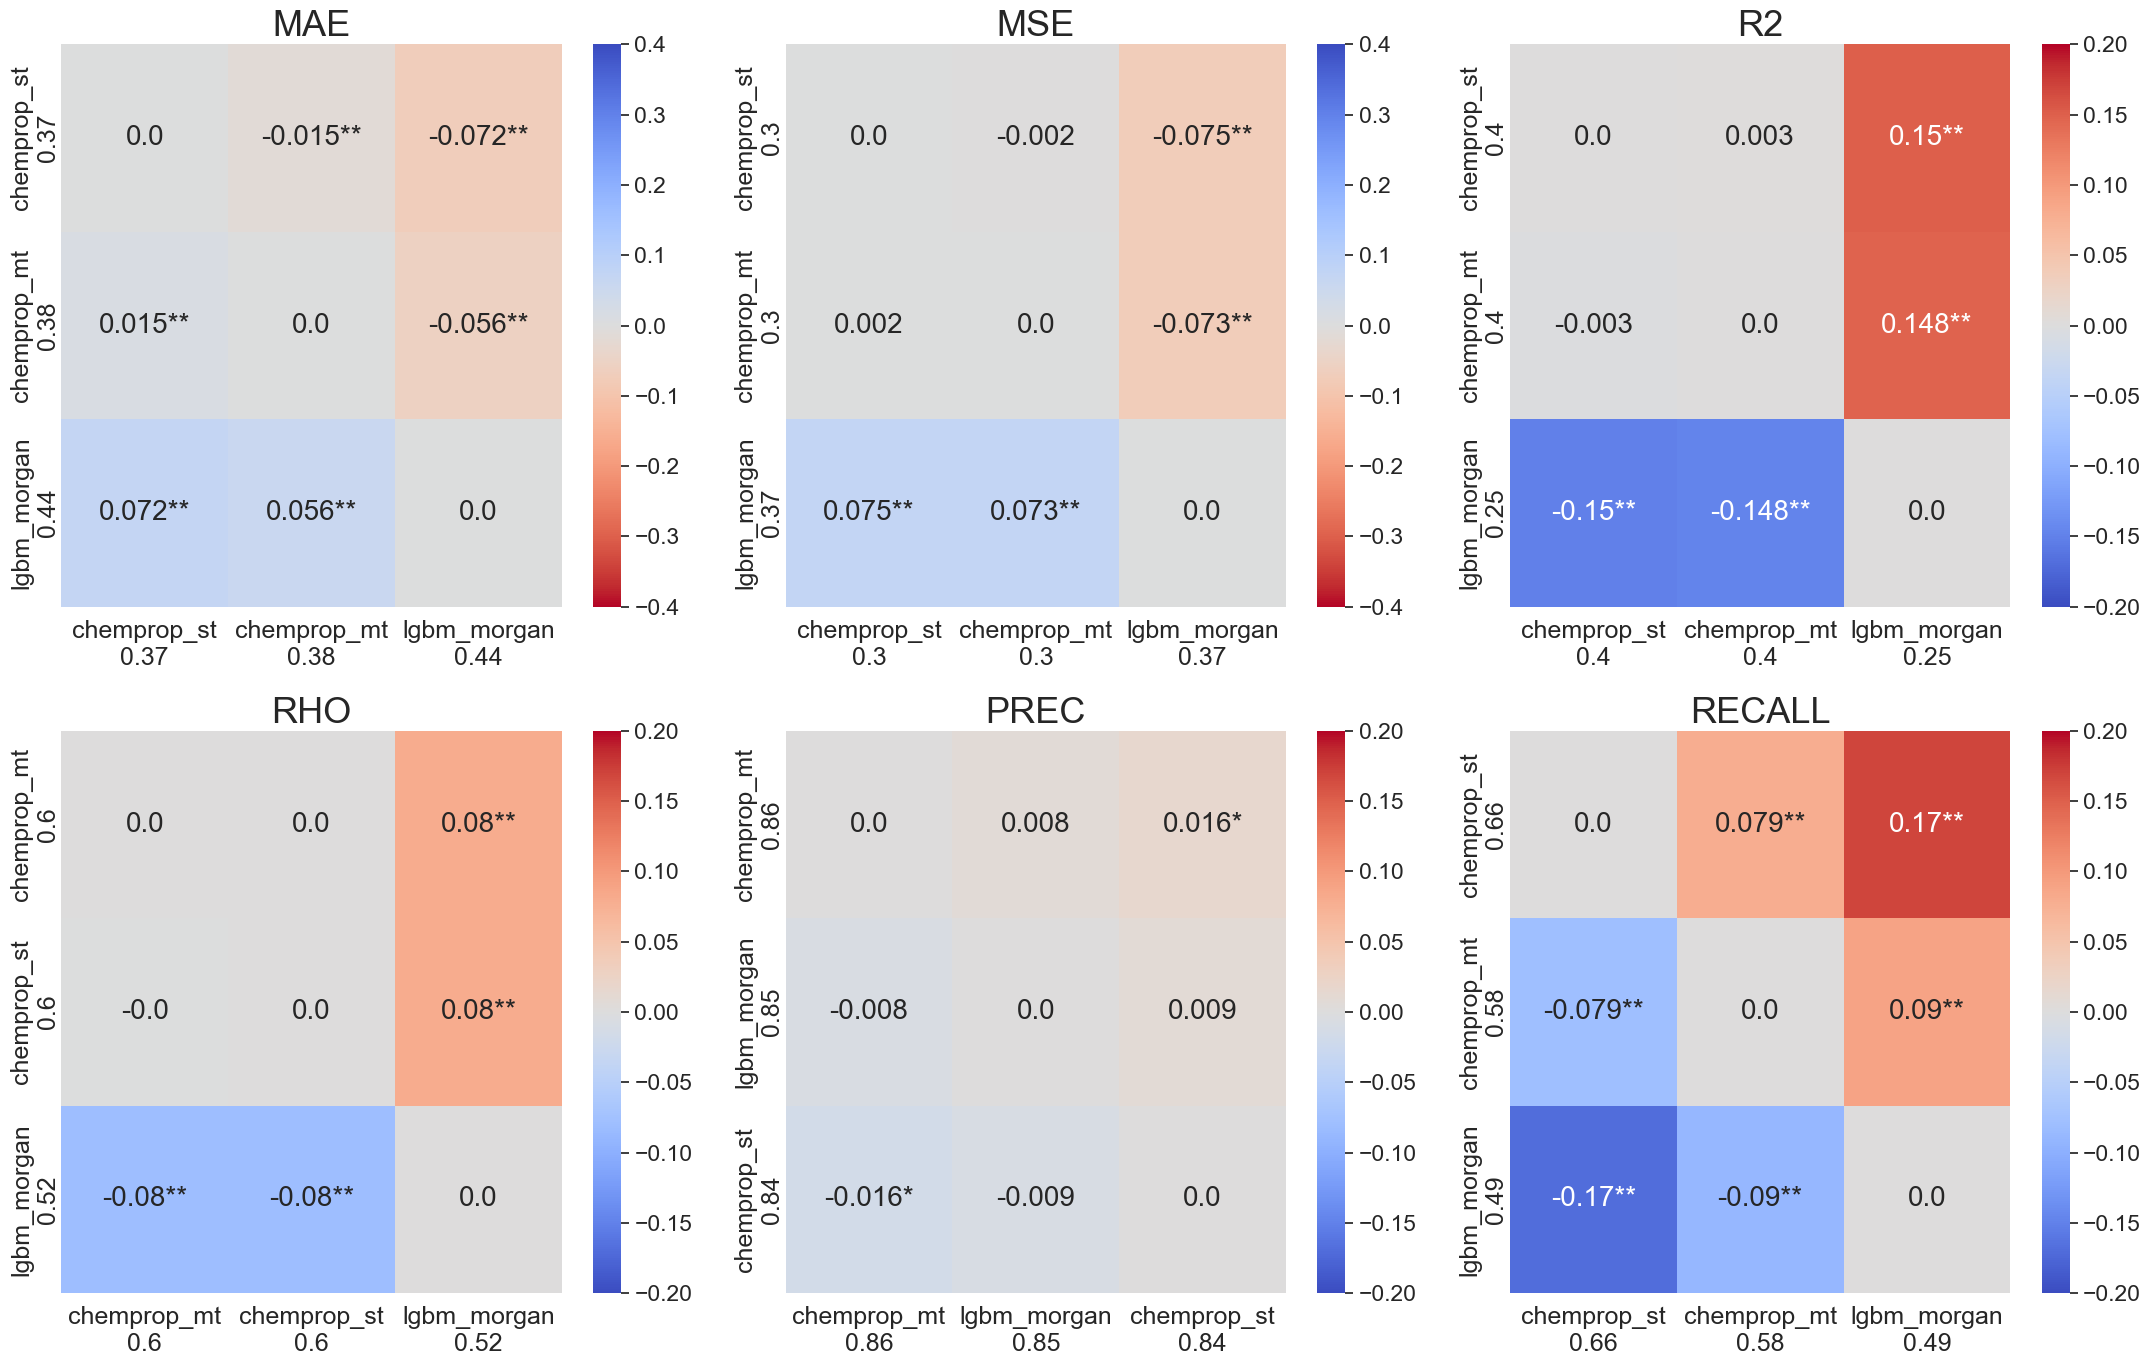

In [33]:
effect_dict = {'mae': .2, 'mse': .2}

make_mcs_plot_grid(df_scaffold_split, metric_ls, group_col="method", effect_dict=effect_dict,
                   figsize=(22, 14), cell_text_size=20, axis_text_size=18, title_text_size=26, show_diff=True, sort_axes=True)

### 6.2 Examine if performance differences are actually meaningful by looking at a scatterplot

There are statistically significant differences in MAE, MSE and R2 between lightGBM and chemprop, but is the effect size large enough to be meaningful? If we examine the precision and recall at the 100uM threshold, we see that precision stays constant (more or less) but recall is substantially lower for lightGBM. If you were to use these models as a compound filter at 100uM, chemprop_st would filter out less positives than lightgbm. The estimated improvement in recall of chemprop_st over lightGBM is .17 (.15, .19), meaning chemprop_st would identify 17% more molecules with good solubility. This would likely have a real practical impact on drug discovery programs. 

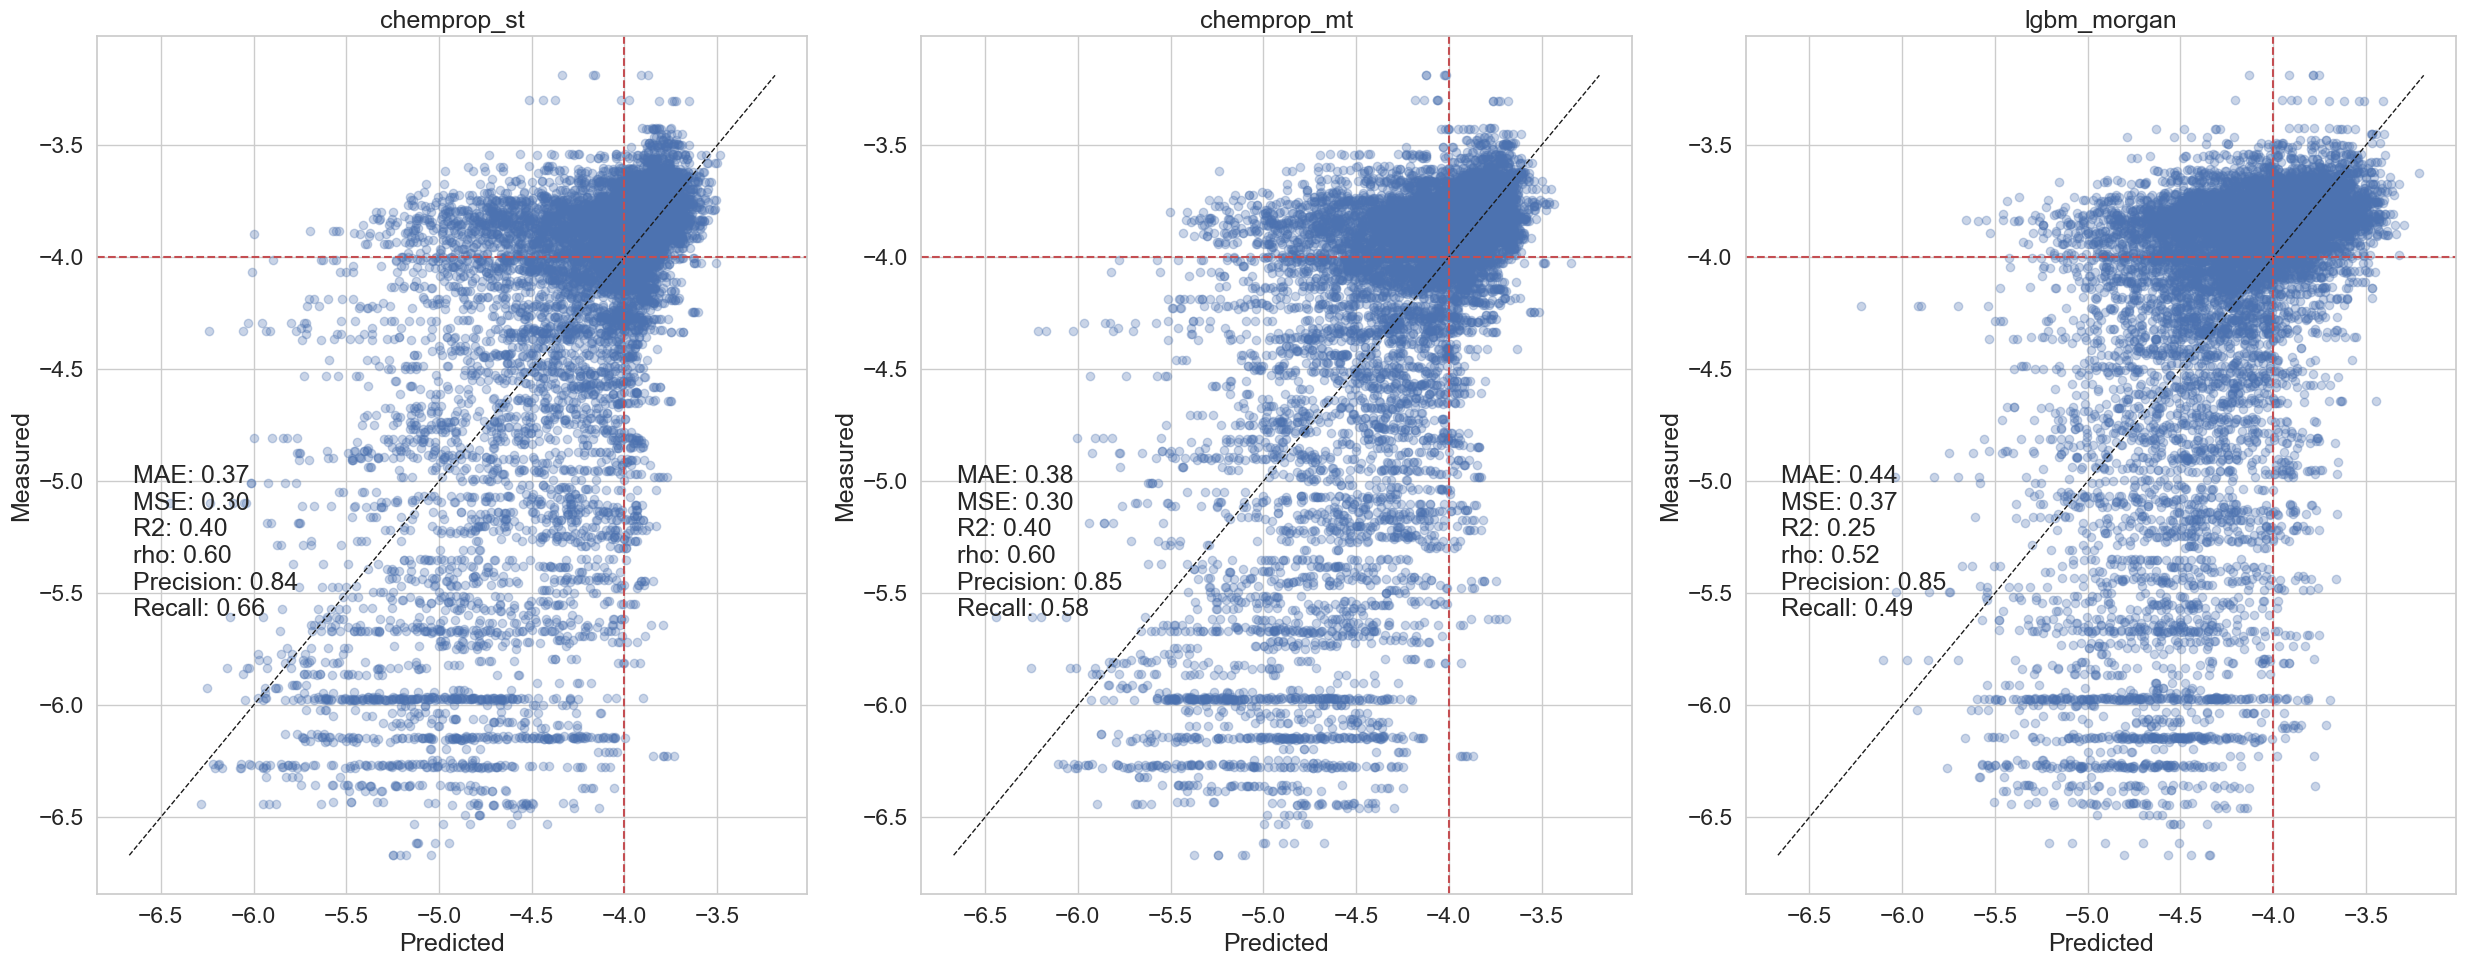

In [25]:
df_scaffold_in = df_input.query("split == 'scaffold'")
make_scatterplot(df_scaffold_in, "Sol", "Sol_pred", thresh=-4, cycle_col="cv_cycle", group_col="method") 

## 7 Supplementary materials

### 7.1 Difference confidence intervals
You can use TukeyHSD to construct confidence intervals for the differences such that uncertainty in the difference estimate is accounted for. The plot below was adapted from [multicomp](https://cran.r-project.org/web/packages/multcomp/vignettes/generalsiminf.pdf) in R. Intervals that do not cross the zero line imply statistical significance. 

As the number of comparisons gets large, the number of pairwise comparisons will become difficult to visualize in one plot. We therefore recommend providing these results in the supplementary as either a plot or tabular form. Alternatively, you may find it optimal to only show a few differences of interest. But remember to apply the TukeyHSD to all comparisons that were examined originally, to avoid [data dredging](https://en.wikipedia.org/wiki/Data_dredging).

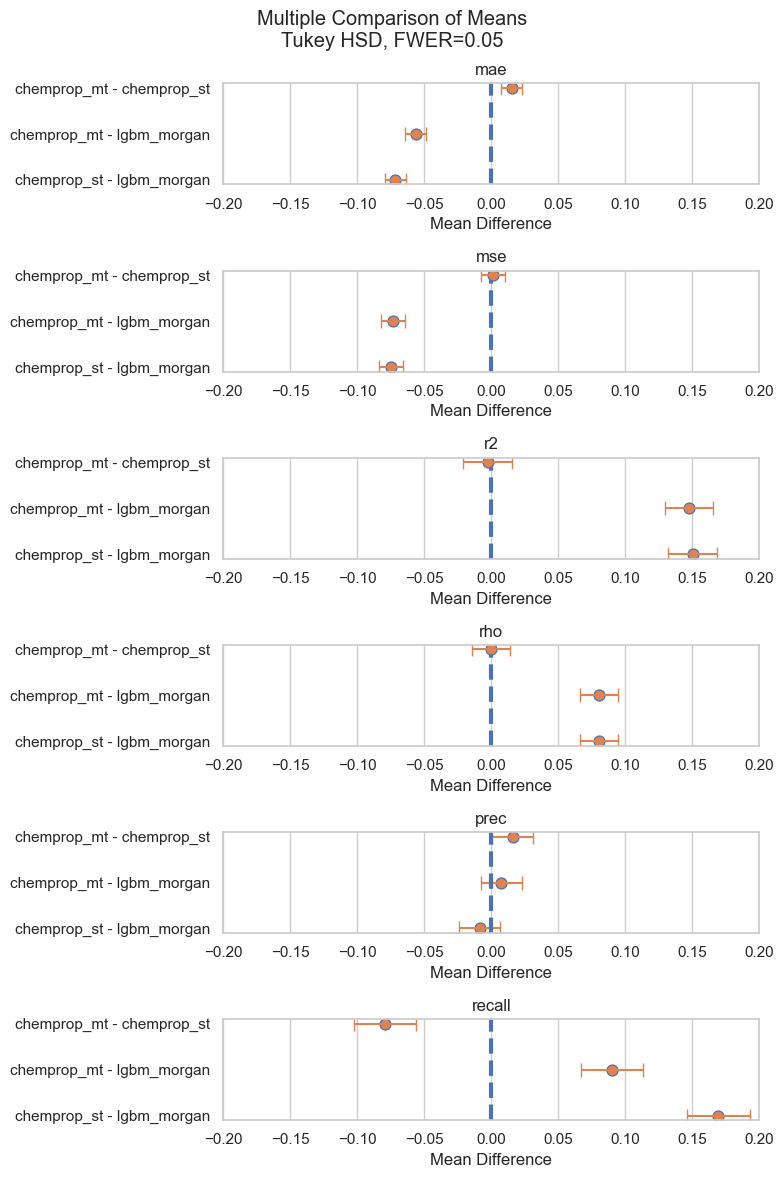

In [25]:
make_ci_plot_grid(df_scaffold_split, metric_ls, "method")

For difference confidence intervals in tabular form:

In [ ]:
rm_tukey_hsd(df_scaffold_split, "r2", "method")[0]

,group1,group2,meandiff,lower,upper,p-adj,group1_mean,group2_mean
chemprop_mt - chemprop_st,chemprop_mt,chemprop_st,-0.002624,-0.020822,0.015574,0.9,0.401235,0.403859
chemprop_mt - lgbm_morgan,chemprop_mt,lgbm_morgan,0.147611,0.129413,0.165809,0.001,0.401235,0.253624
chemprop_st - lgbm_morgan,chemprop_st,lgbm_morgan,0.150235,0.132037,0.168433,0.001,0.403859,0.253624
